<a href="https://colab.research.google.com/github/NaelaTarannum/EVA5/blob/master/session5/step3/step3_aug_lr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# New Section

##**STEP 3:**
##Target:


1.   Keeping the accuracy rise stable.
2.   Added augmentation:rotating the images by an angle to 7 degrees
3.   Using Sgd scheduler

##Result:




1.   Parameters: 16k
2.   Best test accuracy: 99.31
3.   Best Train accuracy: 99.46 


##Analysis:


1.   Model doing pretty well,train accuracy is less than test accuracy,so the model trained hard.
2.    Accuracy doesnt seem to go over 99.5
3.    Learning the intuition behind setting the LR and adding a scheduler might help make the model better.

# Import Libraries

In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [ ]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [ ]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# Dataloader Arguments & Test/Train Dataloaders


In [ ]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# The model
Let's start with the model we first saw

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)   
        self.bn1 = nn.BatchNorm2d(16)                 
        self.conv2 = nn.Conv2d(16, 16, 3, padding=1) 
        self.bn2 = nn.BatchNorm2d(16)                 
        self.pool1 = nn.MaxPool2d(2, 2)       
        self.conv3 = nn.Conv2d(16, 16, 3, padding=1) 
        self.bn3 = nn.BatchNorm2d(16)                 
        self.conv4 = nn.Conv2d(16, 16, 3, padding=1)  
        self.bn4 = nn.BatchNorm2d(16)                
        self.pool2 = nn.MaxPool2d(2, 2)            
        self.conv5 = nn.Conv2d(16, 16, 3)            
        self.bn5 = nn.BatchNorm2d(16)         
        self.conv6 = nn.Conv2d(16, 32, 3)       
        self.bn6 = nn.BatchNorm2d(32)             
        self.conv7= nn.Conv2d(32,16,kernel_size=1)   
        self.conv8 = nn.Conv2d(16, 10, 3) 
        self.dout = nn.Dropout(0.2)         



    def forward(self, x):
        x = self.pool1(self.bn2(F.relu(self.conv2(self.bn1(F.relu(self.conv1(x)))))))
        x = self.dout(x)                            #Was trying to run the model without dropout.But using dropout twice
        x = self.pool2(self.bn4(F.relu(self.conv4(self.bn3(F.relu(self.conv3(x)))))))
        x = self.dout(x)
        x = self.bn6(F.relu(self.conv6(self.bn5(F.relu(self.conv5(x))))))
        x = self.conv7(x)
        x = self.conv8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
       BatchNorm2d-2           [-1, 16, 28, 28]              32
            Conv2d-3           [-1, 16, 28, 28]           2,320
       BatchNorm2d-4           [-1, 16, 28, 28]              32
         MaxPool2d-5           [-1, 16, 14, 14]               0
           Dropout-6           [-1, 16, 14, 14]               0
            Conv2d-7           [-1, 16, 14, 14]           2,320
       BatchNorm2d-8           [-1, 16, 14, 14]              32
            Conv2d-9           [-1, 16, 14, 14]           2,320
      BatchNorm2d-10           [-1, 16, 14, 14]              32
        MaxPool2d-11             [-1, 16, 7, 7]               0
          Dropout-12             [-1, 16, 7, 7]               0
           Conv2d-13             [-1, 16, 5, 5]           2,320
      BatchNorm2d-14             [

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [ ]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)


EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    # scheduler.step()
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
Loss=0.13154588639736176 Batch_id=468 Accuracy=93.34: 100%|██████████| 469/469 [00:24<00:00, 19.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0429, Accuracy: 9862/10000 (98.62%)

EPOCH: 1


Loss=0.040581706911325455 Batch_id=468 Accuracy=98.11: 100%|██████████| 469/469 [00:23<00:00, 19.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0303, Accuracy: 9902/10000 (99.02%)

EPOCH: 2


Loss=0.05010463297367096 Batch_id=468 Accuracy=98.46: 100%|██████████| 469/469 [00:23<00:00, 19.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0285, Accuracy: 9901/10000 (99.01%)

EPOCH: 3


Loss=0.024311160668730736 Batch_id=468 Accuracy=98.66: 100%|██████████| 469/469 [00:23<00:00, 19.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0261, Accuracy: 9917/10000 (99.17%)

EPOCH: 4


Loss=0.029927412047982216 Batch_id=468 Accuracy=98.79: 100%|██████████| 469/469 [00:23<00:00, 19.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9933/10000 (99.33%)

EPOCH: 5


Loss=0.02330346405506134 Batch_id=468 Accuracy=98.86: 100%|██████████| 469/469 [00:23<00:00, 20.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0229, Accuracy: 9926/10000 (99.26%)

EPOCH: 6


Loss=0.02517692930996418 Batch_id=468 Accuracy=98.87: 100%|██████████| 469/469 [00:23<00:00, 20.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 9930/10000 (99.30%)

EPOCH: 7


Loss=0.054741788655519485 Batch_id=468 Accuracy=99.01: 100%|██████████| 469/469 [00:23<00:00, 20.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Accuracy: 9933/10000 (99.33%)

EPOCH: 8


Loss=0.0665275976061821 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:23<00:00, 20.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0216, Accuracy: 9929/10000 (99.29%)

EPOCH: 9


Loss=0.06677678972482681 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:23<00:00, 20.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0191, Accuracy: 9941/10000 (99.41%)

EPOCH: 10


Loss=0.017393099144101143 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:23<00:00, 20.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0190, Accuracy: 9940/10000 (99.40%)

EPOCH: 11


Loss=0.05123038589954376 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:23<00:00, 20.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0181, Accuracy: 9945/10000 (99.45%)

EPOCH: 12


Loss=0.005302441772073507 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:23<00:00, 20.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0163, Accuracy: 9946/10000 (99.46%)

EPOCH: 13


Loss=0.010602183640003204 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:23<00:00, 20.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0196, Accuracy: 9936/10000 (99.36%)

EPOCH: 14


Loss=0.01783921755850315 Batch_id=468 Accuracy=99.30: 100%|██████████| 469/469 [00:23<00:00, 20.27it/s]



Test set: Average loss: 0.0175, Accuracy: 9942/10000 (99.42%)



# Let's Train and test our model

This time let's add a scheduler for out LR. 

Text(0.5, 1.0, 'Test Accuracy')

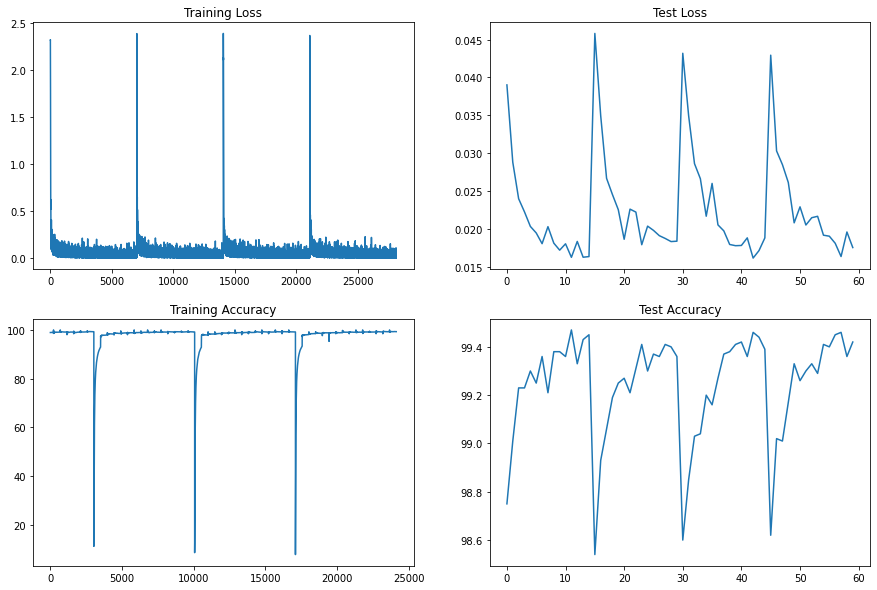

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")